# Chapter 7. Ulysses’ Compass

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd

from jax import lax, ops, vmap
import jax.numpy as np
from jax.random import PRNGKey, fold_in
from jax.scipy.special import logsumexp

import numpyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
from numpyro.infer import ELBO, Predictive, SVI, init_to_value, log_likelihood
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = (lambda message, category, *args, **kwargs:
                          "{}: {}\n".format(category.__name__, message))
az.style.use("arviz-darkgrid")

### Code 7.1

In [2]:
sppnames = ["afarensis", "africanus", "habilis", "boisei",
            "rudolfensis", "ergaster", "sapiens"]
brainvolcc = np.array([438, 452, 612, 521, 752, 871, 1350])
masskg = np.array([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})

### Code 7.2

In [3]:
d["mass_std"] = (d.mass - d.mass.mean()) / d.mass.std()
d["brain_std"] = d.brain / d.brain.max()

### Code 7.3

In [4]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = a + b * mass_std
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("brain_std", dist.Normal(mu, np.exp(log_sigma)),
                 obs=brain_std)

m7_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m7_1, optim.Adam(0.3), AutoContinuousELBO(),
          mass_std=d.mass_std.values, brain_std=d.brain_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p7_1 = svi.get_params(state)

### Code 7.4

In [5]:
def model(mass_std, brain_std):
    intercept = numpyro.sample("intercept", dist.Normal(0, 10))
    b_mass_std = numpyro.sample("b_mass_std", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(2))
    mu = intercept + b_mass_std * mass_std
    numpyro.sample("brain_std", dist.Normal(mu, sigma), obs=brain_std)

m7_1_OLS = AutoLaplaceApproximation(model)
svi = SVI(model, m7_1_OLS, optim=optim.Adam(0.01), loss=AutoContinuousELBO(),
          mass_std=d.mass_std.values, brain_std=d.brain_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p7_1_OLS = svi.get_params(state)
post = m7_1_OLS.sample_posterior(PRNGKey(1), p7_1_OLS, (1000,))

### Code 7.5

In [6]:
post = m7_1.sample_posterior(PRNGKey(12), p7_1, (1000,))
s = Predictive(m7_1.model, post).get_samples(PRNGKey(2), d.mass_std.values)
r = np.mean(s["brain_std"], 0) - d.brain_std.values
resid_var = np.var(r, ddof=1)
outcome_var = np.var(d.brain_std.values, ddof=1)
1 - resid_var / outcome_var

DeviceArray(0.4915679, dtype=float32)

### Code 7.6

In [7]:
def R2_is_bad(quap_fit):
    quap, params = quap_fit
    post = quap.sample_posterior(PRNGKey(1), params, (1000,))
    s = Predictive(quap.model, post).get_samples(PRNGKey(2), d.mass_std.values)
    r = np.mean(s["brain_std"], 0) - d.brain_std.values
    return 1 - np.var(r, ddof=1) / np.var(d.brain_std.values, ddof=1)

### Code 7.7

In [8]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10), sample_shape=(2,))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = a + b[0] * mass_std + b[1] * mass_std ** 2
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("brain_std", dist.Normal(mu, np.exp(log_sigma)),
                 obs=brain_std)

m7_2 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value({"b": np.repeat(0., 2)}))
svi = SVI(model, m7_2, optim.Adam(0.3), AutoContinuousELBO(),
          mass_std=d.mass_std.values, brain_std=d.brain_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p7_2 = svi.get_params(state)

### Code 7.8

In [9]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10), sample_shape=(3,))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = a + b[0] * mass_std + b[1] * mass_std ** 2 + b[2] * mass_std ** 3
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("brain_std", dist.Normal(mu, np.exp(log_sigma)),
                 obs=brain_std)

m7_3 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value({"b": np.repeat(0., 3)}))
svi = SVI(model, m7_3, optim.Adam(0.01), AutoContinuousELBO(),
          mass_std=d.mass_std.values, brain_std=d.brain_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p7_3 = svi.get_params(state)

def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10), sample_shape=(4,))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = a + np.sum(b * np.power(mass_std[..., None], np.arange(1, 5)), -1)
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("brain_std", dist.Normal(mu, np.exp(log_sigma)),
                 obs=brain_std)

m7_4 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value({"b": np.repeat(0., 4)}))
svi = SVI(model, m7_4, optim.Adam(0.01), AutoContinuousELBO(),
          mass_std=d.mass_std.values, brain_std=d.brain_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p7_4 = svi.get_params(state)

def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10), sample_shape=(5,))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = a + np.sum(b * np.power(mass_std[..., None], np.arange(1, 6)), -1)
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("brain_std", dist.Normal(mu, np.exp(log_sigma)),
                 obs=brain_std)

m7_5 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value({"b": np.repeat(0., 5)}))
svi = SVI(model, m7_5, optim.Adam(0.01), AutoContinuousELBO(),
          mass_std=d.mass_std.values, brain_std=d.brain_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p7_5 = svi.get_params(state)

### Code 7.9

In [10]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10), sample_shape=(6,))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = a + np.sum(b * np.power(mass_std[..., None], np.arange(1, 7)), -1)
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("brain_std", dist.Normal(mu, np.exp(log_sigma)),
                 obs=brain_std)

m7_6 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value({"b": np.repeat(0., 6)}))
svi = SVI(model, m7_6, optim.Adam(0.003), AutoContinuousELBO(),
          mass_std=d.mass_std.values, brain_std=d.brain_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(5000))
p7_6 = svi.get_params(state)

### Code 7.10

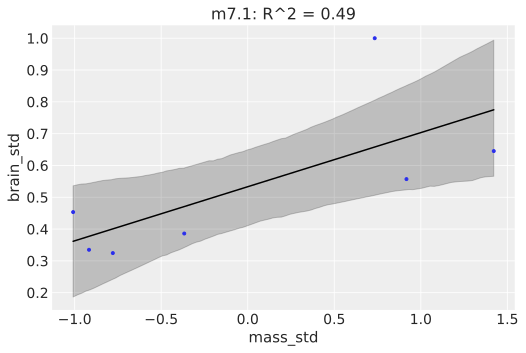

In [11]:
post = m7_1.sample_posterior(PRNGKey(1), p7_1, (1000,))
mass_seq = np.linspace(d.mass_std.min(), d.mass_std.max(), num=100)
l = Predictive(m7_1.model, post, return_sites=["mu"]).get_samples(
    PRNGKey(2), mass_std=mass_seq)["mu"]
mu = np.mean(l, 0)
ci = np.percentile(l, (4.5, 95.5), 0)
az.plot_pair(d[["mass_std", "brain_std"]].to_dict("list"))
plt.plot(mass_seq, mu, "k")
plt.fill_between(mass_seq, ci[0], ci[1], color="k", alpha=0.2)
plt.title("m7.1: R^2 = {:0.2f}".format(R2_is_bad((m7_1, p7_1)).item()));

### Code 7.11

In [12]:
i = 1
d_minus_i = d.drop(i)

### Code 7.12

In [13]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

DeviceArray(0.61086434, dtype=float32)

### Code 7.13

In [14]:
def lppd_fn(seed, quad, params, num_samples=1000):
    post = quad.sample_posterior(PRNGKey(1), params, (int(1e4),))
    logprob = log_likelihood(
        quad.model, post, d.mass_std.values, d.brain_std.values)["brain_std"]
    return logsumexp(logprob, 0) - np.log(logprob.shape[0])

lppd_fn(PRNGKey(1), m7_1, p7_1, int(1e4))

DeviceArray([ 0.62054443,  0.6559582 ,  0.5376129 ,  0.63189507,
              0.4610052 ,  0.42532063, -0.8318138 ], dtype=float32)

### Code 7.14

In [15]:
post = m7_1.sample_posterior(PRNGKey(1), p7_1, (int(1e4),))
logprob = log_likelihood(
    m7_1.model, post, d.mass_std.values, d.brain_std.values)["brain_std"]
n = logprob.shape[1]
ns = logprob.shape[0]
f = lambda i: logsumexp(logprob[:, i]) - np.log(ns)
lppd = vmap(f)(np.arange(n))
lppd

DeviceArray([ 0.62054443,  0.6559582 ,  0.5376129 ,  0.63189507,
              0.4610052 ,  0.42532063, -0.8318138 ], dtype=float32)

### Code 7.15

In [16]:
[np.sum(lppd_fn(PRNGKey(1), m[0], m[1])).item()
 for m in ((m7_1, p7_1), (m7_2, p7_2), (m7_3, p7_3),
           (m7_4, p7_4), (m7_5, p7_5), (m7_6, p7_6))]

[2.5005226135253906,
 1.497262954711914,
 3.669788360595703,
 5.340777397155762,
 14.07225513458252,
 18.861244201660156]

### Code 7.16

In [17]:
def model(mm, y, b_sigma):
    a = numpyro.param("a", np.array([0.]))
    Bvec = a
    k = mm.shape[1]
    if k > 1:
        b = numpyro.sample("b", dist.Normal(0, b_sigma), sample_shape=(k - 1,))
        Bvec = np.concatenate([Bvec, b])
    mu = np.matmul(mm, Bvec)
    numpyro.sample("y", dist.Normal(mu, 1), obs=y)

def sim_train_test(i, N=20, k=3, rho=[0.15, -0.4], b_sigma=100):
    n_dim = max(k, 3)
    Rho = np.identity(n_dim)
    Rho = ops.index_update(Rho, ops.index[1:len(rho) + 1, 0], np.array(rho))
    Rho = ops.index_update(Rho, ops.index[0, 1:len(rho) + 1], np.array(rho))

    X_train = dist.MultivariateNormal(np.zeros(n_dim), Rho).sample(
        fold_in(PRNGKey(0), i), (N,))
    mm_train = np.ones((N, 1))
    if k > 1:
        mm_train = np.concatenate([mm_train, X_train[:, 1:k]], axis=1)

    if k > 1:
        m = AutoLaplaceApproximation(
            model, init_strategy=init_to_value({"b": np.zeros(k - 1)}))
        loss = AutoContinuousELBO()
    else:
        m = lambda mm, y, b_sigma: None
        loss = ELBO()
    svi = SVI(model, m, optim.Adam(0.3), loss,
              mm=mm_train, y=X_train[:, 0], b_sigma=b_sigma)
    init_state = svi.init(fold_in(PRNGKey(1), i))
    state, loss = lax.scan(
        lambda x, i: svi.update(x), init_state, np.zeros(1000))
    params = svi.get_params(state)
    coefs = params["a"]
    if k > 1:
        coefs = np.concatenate([coefs, m.median(params)["b"]])

    logprob = dist.Normal(np.matmul(mm_train, coefs)).log_prob(X_train[:, 0])
    dev_train = (-2) * np.sum(logprob)

    X_test = dist.MultivariateNormal(np.zeros(n_dim), Rho).sample(
        fold_in(PRNGKey(2), i), (N,))
    mm_test = np.ones((N, 1))
    if k > 1:
        mm_test = np.concatenate([mm_test, X_test[:, 1:k]], axis=1)
    logprob = dist.Normal(np.matmul(mm_test, coefs)).log_prob(X_test[:, 0])
    dev_test = (-2) * np.sum(logprob)
    return np.stack([dev_train, dev_test])

def dev_fn(N, k):
    print(k)
    r = lax.map(lambda i: sim_train_test(i, N, k), np.arange((int(1e4))))
    return np.concatenate([np.mean(r, 0), np.std(r, 0)])

N = 20
kseq = range(1, 6)
dev = np.stack([dev_fn(N, k) for k in kseq], axis=1)

1
2
3
4
5


### Code 7.17

In [18]:
def dev_fn(N, k):
    print(k)
    r = vmap(lambda i: sim_train_test(i, N, k))(np.arange((int(1e4))))
    return np.concatenate([np.mean(r, 0), np.std(r, 0)])

### Code 7.18

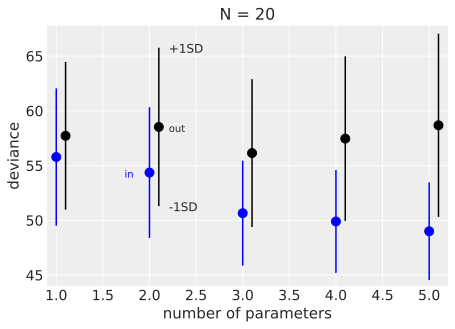

In [19]:
plt.subplot(ylim=(np.min(dev[0]).item() - 5, np.max(dev[0]).item() + 12),
            xlim=(0.9, 5.2), xlabel="number of parameters", ylabel="deviance")
plt.title("N = {}".format(N))
plt.scatter(np.arange(1, 6), dev[0], s=80, color="b")
plt.scatter(np.arange(1.1, 6), dev[1], s=80, color="k")
pts_int = (dev[0] - dev[2], dev[0] + dev[2])
pts_out = (dev[1] - dev[3], dev[1] + dev[3])
plt.vlines(np.arange(1, 6), pts_int[0], pts_int[1], color="b")
plt.vlines(np.arange(1.1, 6), pts_out[0], pts_out[1], color="k")
plt.annotate("in", (2, dev[0][1]), xytext=(-25, -5),
             textcoords="offset pixels", color="b")
plt.annotate("out", (2.1, dev[1][1]), xytext=(10, -5),
             textcoords="offset pixels")
plt.annotate("+1SD", (2.1, pts_out[1][1]), xytext=(10, -5),
             textcoords="offset pixels", fontsize=12)
plt.annotate("-1SD", (2.1, pts_out[0][1]), xytext=(10, -5),
             textcoords="offset pixels", fontsize=12);

### Code 7.19

In [20]:
cars = pd.read_csv("../data/cars.csv", sep=",")

def model(speed, cars_dist):
    a = numpyro.sample("a", dist.Normal(0, 100))
    b = numpyro.sample("b", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + b * speed
    numpyro.sample("dist", dist.Normal(mu, sigma), obs=cars_dist)

m = AutoLaplaceApproximation(model)
svi = SVI(model, m, optim.Adam(1), AutoContinuousELBO(),
          speed=cars.speed.values, cars_dist=cars.dist.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
params = svi.get_params(state)
post = m.sample_posterior(PRNGKey(94), params, (1000,))

### Code 7.20

In [21]:
n_samples = 1000

def logprob_fn(s):
    mu = post["a"][s] + post["b"][s] * cars.speed.values
    return dist.Normal(mu, post["sigma"][s]).log_prob(cars.dist.values)

logprob = vmap(logprob_fn, out_axes=1)(np.arange(n_samples))

### Code 7.21

In [22]:
n_cases = cars.shape[0]
lppd = logsumexp(logprob, 1) - np.log(n_samples)

### Code 7.22

In [23]:
pWAIC = np.var(logprob, 1)

### Code 7.23

In [24]:
-2 * (np.sum(lppd) - np.sum(pWAIC))

DeviceArray(422.60367, dtype=float32)

### Code 7.24

In [25]:
waic_vec = -2 * (lppd - pWAIC)
np.sqrt(n_cases * np.var(waic_vec))

DeviceArray(17.004904, dtype=float32)

### Code 7.25

In [26]:
with numpyro.handlers.seed(rng=71):
    # number of plants
    N = 100

    # simulate initial heights
    h0 = numpyro.sample("h0", dist.Normal(10, 2), sample_shape=(N,))

    # assign treatments and simulate fungus and growth
    treatment = np.repeat(np.arange(2), repeats=N // 2)
    fungus = numpyro.sample(
        "fungus", dist.Binomial(total_count=1, probs=(0.5 - treatment * 0.4)))
    h1 = h0 + numpyro.sample("diff", dist.Normal(5 - 3 * fungus))

    # compose a clean data frame
    d = pd.DataFrame(
        {"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

def model(h0, h1):
    p = numpyro.sample("p", dist.LogNormal(0, 0.25))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

m6_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_6, optim.Adam(1), AutoContinuousELBO(),
          h0=d.h0.values, h1=d.h1.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_6 = svi.get_params(state)

def model(treatment, fungus, h0, h1):
    a = numpyro.sample("a", dist.LogNormal(0, 0.2))
    bt = numpyro.sample("bt", dist.Normal(0, 0.5))
    bf = numpyro.sample("bf", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    p = a + bt * treatment + bf * fungus
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

m6_7 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_7, optim.Adam(0.3), AutoContinuousELBO(),
          treatment=d.treatment.values, fungus=d.fungus.values,
          h0=d.h0.values, h1=d.h1.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_7 = svi.get_params(state)

def model(treatment, h0, h1):
    a = numpyro.sample("a", dist.LogNormal(0, 0.2))
    bt = numpyro.sample("bt", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    p = a + bt * treatment
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

m6_8 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_8, optim.Adam(1), AutoContinuousELBO(),
          treatment=d.treatment.values, h0=d.h0.values, h1=d.h1.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_8 = svi.get_params(state)

post = m6_7.sample_posterior(PRNGKey(11), p6_7, (1000,))
logprob = log_likelihood(m6_7.model, post,
                         treatment=d.treatment.values, fungus=d.fungus.values,
                         h0=d.h0.values, h1=d.h1.values)
az6_7 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
az.waic(az6_7)

See http://arxiv.org/abs/1507.04544 for details


Computed from 1000 by 100 log-likelihood matrix

        Estimate       SE
IC_waic   331.67    15.76
p_waic      4.21        -

There has been a warning during the calculation. Please check the results.

### Code 7.26

In [27]:
post = m6_6.sample_posterior(PRNGKey(77), p6_6, (1000,))
logprob = log_likelihood(m6_6.model, post, h0=d.h0.values, h1=d.h1.values)
az6_6 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
post = m6_7.sample_posterior(PRNGKey(77), p6_7, (1000,))
logprob = log_likelihood(m6_7.model, post,
                         treatment=d.treatment.values, fungus=d.fungus.values,
                         h0=d.h0.values, h1=d.h1.values)
az6_7 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
post = m6_8.sample_posterior(PRNGKey(77), p6_8, (1000,))
logprob = log_likelihood(m6_8.model, post, treatment=d.treatment.values,
                         h0=d.h0.values, h1=d.h1.values)
az6_8 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
az.compare({"m6.6": az6_6, "m6.7": az6_7, "m6.8": az6_8})

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6.7,0,331.568,4.18385,0,0.999988,12.1117,0,True,deviance
m6.8,1,395.65,2.82591,64.082,1.19807e-05,12.9601,14.5155,False,deviance
m6.6,2,407.817,1.80593,76.2484,1.3044e-08,16.1535,15.2995,False,deviance


### Code 7.27

In [28]:
post = m6_7.sample_posterior(PRNGKey(91), p6_7, (1000,))
logprob = log_likelihood(m6_7.model, post,
                         treatment=d.treatment.values, fungus=d.fungus.values,
                         h0=d.h0.values, h1=d.h1.values)
az6_7 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
waic_m6_7 = az.waic(az6_7, pointwise=True)
post = m6_8.sample_posterior(PRNGKey(91), p6_8, (1000,))
logprob = log_likelihood(m6_8.model, post, treatment=d.treatment.values,
                         h0=d.h0.values, h1=d.h1.values)
az6_8 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
waic_m6_8 = az.waic(az6_8, pointwise=True)
n = waic_m6_7.n_data_points
diff_m6_7_m6_8 = waic_m6_7.waic_i.values - waic_m6_8.waic_i.values
np.sqrt(n * np.var(diff_m6_7_m6_8))

DeviceArray(14.547715, dtype=float32)

### Code 7.28

In [29]:
40.0 + np.array([-1, 1]) * 10.4 * 2.6

DeviceArray([12.960003, 67.03999 ], dtype=float32)

### Code 7.29

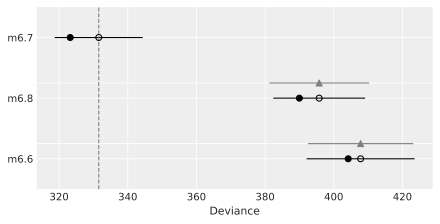

In [30]:
compare = az.compare({"m6.6": az6_6, "m6.7": az6_7, "m6.8": az6_8})
az.plot_compare(compare);

### Code 7.30

In [31]:
post = m6_6.sample_posterior(PRNGKey(92), p6_6, (1000,))
logprob = log_likelihood(m6_6.model, post, h0=d.h0.values, h1=d.h1.values)
az6_6 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
waic_m6_6 = az.waic(az6_6, pointwise=True)
diff_m6_6_m6_8 = waic_m6_6.waic_i.values - waic_m6_8.waic_i.values
np.sqrt(n * np.var(diff_m6_6_m6_8))

DeviceArray(7.312679, dtype=float32)

### Code 7.31

In [32]:
post = m6_6.sample_posterior(PRNGKey(93), p6_6, (1000,))
logprob = log_likelihood(m6_6.model, post, h0=d.h0.values, h1=d.h1.values)
az6_6 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
waic_m6_6 = az.waic(az6_6, pointwise=True)
post = m6_7.sample_posterior(PRNGKey(93), p6_7, (1000,))
logprob = log_likelihood(m6_7.model, post,
                         treatment=d.treatment.values, fungus=d.fungus.values,
                         h0=d.h0.values, h1=d.h1.values)
az6_7 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
waic_m6_7 = az.waic(az6_7, pointwise=True)
post = m6_8.sample_posterior(PRNGKey(93), p6_8, (1000,))
logprob = log_likelihood(m6_8.model, post, treatment=d.treatment.values,
                         h0=d.h0.values, h1=d.h1.values)
az6_8 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
waic_m6_8 = az.waic(az6_8, pointwise=True)
dSE = lambda waic1, waic2: np.sqrt(
    n * np.var(waic1.waic_i.values - waic2.waic_i.values))
data = {"m6.6": waic_m6_6, "m6.7": waic_m6_7, "m6.8": waic_m6_8}
pd.DataFrame(
    {row: {col: dSE(row_val, col_val) for col, col_val in data.items()}
     for row, row_val in data.items()})

,m6.6,m6.7,m6.8
m6.6,0.0,15.321122,7.376811
m6.7,15.321122,0.0,14.536517
m6.8,7.376811,14.536517,0.0


### Code 7.32

In [33]:
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

def model(A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bA * A
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)

m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), AutoContinuousELBO(),
          A=d.A.values, D=d.D.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_1 = svi.get_params(state)

def model(M, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)

m5_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_2, optim.Adam(1), AutoContinuousELBO(),
          M=d.M.values, D=d.D.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_2 = svi.get_params(state)

def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M + bA * A
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)

m5_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_3, optim.Adam(1), AutoContinuousELBO(),
          M=d.M.values, A=d.A.values, D=d.D.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_3 = svi.get_params(state)

### Code 7.33

In [34]:
post = m5_1.sample_posterior(PRNGKey(24071847), p5_1, (1000,))
logprob = log_likelihood(m5_1.model, post, A=d.A.values, D=d.D.values)["D"]
az5_1 = az.from_dict(posterior={k: v[None, ...] for k, v in post.items()},
                     sample_stats={"log_likelihood": logprob[None, ...]})
post = m5_2.sample_posterior(PRNGKey(24071847), p5_2, (1000,))
logprob = log_likelihood(m5_2.model, post, M=d.M.values, D=d.D.values)["D"]
az5_2 = az.from_dict(posterior={k: v[None, ...] for k, v in post.items()},
                     sample_stats={"log_likelihood": logprob[None, ...]})
post = m5_3.sample_posterior(PRNGKey(24071847), p5_3, (1000,))
logprob = log_likelihood(m5_3.model, post, A=d.A.values, M=d.M.values,
                         D=d.D.values)["D"]
az5_3 = az.from_dict(posterior={k: v[None, ...] for k, v in post.items()},
                     sample_stats={"log_likelihood": logprob[None, ...]})
az.compare({"m5.1": az5_1, "m5.2": az5_2, "m5.3": az5_3})

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m5.1,0,126.516,4.10817,0,0.658332,13.1158,0,True,deviance
m5.3,1,128.989,5.68405,2.47345,0.229808,9.83282,1.36839,True,deviance
m5.2,2,139.776,3.28265,13.2601,0.11186,14.1675,9.84543,True,deviance


### Code 7.34

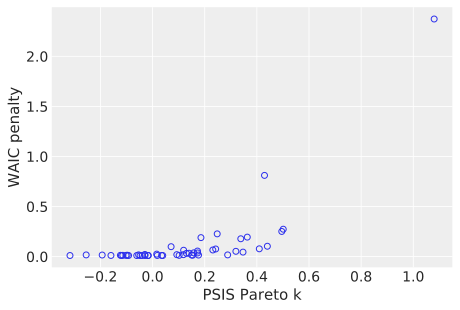

In [35]:
PSIS_m5_3 = az.loo(az5_3, pointwise=True)
WAIC_m5_3 = az.waic(az5_3, pointwise=True)
penalty = az5_3.sample_stats.log_likelihood.stack(
    sample=("chain", "draw")).var(dim="sample").values
plt.plot(PSIS_m5_3.pareto_k.values, penalty, "o", mfc="none")
plt.gca().set(xlabel="PSIS Pareto k", ylabel="WAIC penalty");

### Code 7.35

In [36]:
def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M + bA * A
    numpyro.sample("D", dist.StudentT(2, mu, sigma), obs=D)

m5_3t = AutoLaplaceApproximation(model)
svi = SVI(model, m5_3t, optim.Adam(0.3), AutoContinuousELBO(),
          M=d.M.values, A=d.A.values, D=d.D.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_3t = svi.get_params(state)